In [5]:
import sys, os, time, pickle, sklearn
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import qinfer as qi
import importlib as imp

In [6]:
%matplotlib inline

In [7]:
sys.path.append(os.path.abspath(".."))
import qmla

In [8]:
%run revival_data_lib.py

# Data import

In [9]:
directory = os.path.abspath("C:/Users/AAG/OneDrive/Work @OneDrive/@Bristol OneDrive/QMLA project/QML_share_stateofart/RawSebData_QML/NV05_HahnEcho01_highres")

In [17]:
directory = os.path.abspath("/home/bf16951/QMD/qmla/growth_rules/nv_centre_spin_characterisation/data/NV_revivals.p")

In [11]:
%%capture

xdata, ydata = obtaindata(directory)

IndexError: too many indices for array

In [19]:
revival_data = pickle.load(open(directory, 'rb'))

In [29]:
xdata = np.array(sorted(revival_data.keys()))
ydata = np.array([revival_data[t] for t in xdata])

In [30]:
increment = np.round(np.mean(xdata[1:]-xdata[:-1]), 1)
increment

0.1

In [25]:
xdata

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0,
 1.05,
 1.1,
 1.15,
 1.2,
 1.25,
 1.3,
 1.35,
 1.4,
 1.45,
 1.5,
 1.55,
 1.6,
 1.65,
 1.7,
 1.75,
 1.8,
 1.85,
 1.9,
 1.95,
 2.0,
 2.05,
 2.1,
 2.15,
 2.2,
 2.25,
 2.3,
 2.35,
 2.4,
 2.45,
 2.5,
 2.55,
 2.6,
 2.65,
 2.7,
 2.75,
 2.8,
 2.85,
 2.9,
 2.95,
 3.0,
 3.05,
 3.1,
 3.15,
 3.2,
 3.25,
 3.3,
 3.35,
 3.4,
 3.45,
 3.5,
 3.55,
 3.6,
 3.65,
 3.7,
 3.75,
 3.8,
 3.85,
 3.9,
 3.95,
 4.0,
 4.05,
 4.1,
 4.35,
 4.45,
 4.55,
 4.65,
 4.75,
 4.85,
 4.95,
 5.05,
 5.15,
 5.25,
 5.35,
 5.45,
 5.55,
 5.65,
 5.75,
 5.85,
 5.95,
 6.05,
 6.15,
 6.25,
 6.35,
 6.45,
 6.55,
 6.65,
 6.75,
 6.85,
 6.95,
 7.05,
 7.15,
 7.25,
 7.35,
 7.45,
 7.55,
 7.65,
 7.75,
 7.85,
 7.95,
 8.05,
 8.15,
 8.25,
 8.35,
 8.45,
 8.55,
 8.65,
 8.75,
 8.85,
 8.95,
 9.05,
 9.15,
 9.25,
 9.35,
 9.45,
 9.55,
 9.65,
 9.75,
 9.85,
 9.95,
 10.05,
 10.15,
 10.25,
 10.35,
 10.45,
 10.55,
 10.65,
 10.75

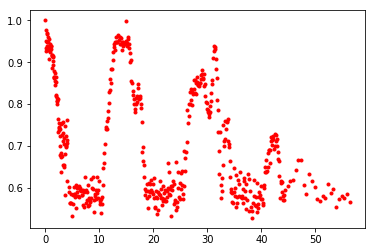

In [31]:
plt.plot(xdata, ydata, "r.", label="Exp. Data")

plt.show()

# Dynamic analysis for Hahn echo experiments

In [32]:
n_qubits = 2
true_model_terms_params = {
    # spin
#     'pauliSet_1_x_d{}'.format(n_qubits) : 1.94e9,
#     'pauliSet_1_y_d{}'.format(n_qubits) : 1.94e9,
    'pauliSet_1_z_d{}'.format(n_qubits) : 2e9,
    
    'pauliSet_1J2_zJz_d{}'.format(n_qubits) : 0.2e6, 
#     'pauliSet_1J3_zJz_d{}'.format(n_qubits) : 2.4e6, 
#     'pauliSet_1J4_zJz_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J5_zJz_d{}'.format(n_qubits) : 2.14e6, 
# #     'pauliSet_1J6_zJz_d{}'.format(n_qubits) : 2.14e6, 

    'pauliSet_1J2_yJy_d{}'.format(n_qubits) : 0.4e6, 
#     'pauliSet_1J3_yJy_d{}'.format(n_qubits) : 2.4e6, 
#     'pauliSet_1J4_yJy_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J5_yJy_d{}'.format(n_qubits) : 2.14e6, 
# #     'pauliSet_1J6_yJy_d{}'.format(n_qubits) : 2.14e6, 

    'pauliSet_1J2_xJx_d{}'.format(n_qubits) : 0.2e6, 
#     'pauliSet_1J3_xJx_d{}'.format(n_qubits) : 2.4e6, 
#     'pauliSet_1J4_xJx_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J5_xJx_d{}'.format(n_qubits) : 2.14e6, 
# #     'pauliSet_1J6_xJx_d{}'.format(n_qubits) : 2.14e6, 

#     # carbon nuclei - 2nd qubit
    'pauliSet_2_x_d{}'.format(n_qubits) : 66e3,
    'pauliSet_2_y_d{}'.format(n_qubits) : 66e3,
    'pauliSet_2_z_d{}'.format(n_qubits) : 15e3,

#     # carbon nuclei - 3rd qubit
#     'pauliSet_3_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_3_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_3_z_d{}'.format(n_qubits) : 117e3,

#     # carbon nuclei - 4th qubit
#     'pauliSet_4_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_4_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_4_z_d{}'.format(n_qubits) : 117e3,

#     # carbon nuclei - 5th qubit
#     'pauliSet_5_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_5_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_5_z_d{}'.format(n_qubits) : 117e3,

    # carbon nuclei - 6th qubit
#     'pauliSet_6_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_6_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_6_z_d{}'.format(n_qubits) : 117e3,
    
    # nitrogen nuclei // NEGLECTED
}

In [33]:
true_model = '+'.join(
    (true_model_terms_params.keys())
)
true_model = qmla.construct_models.alph(true_model)
true_model

'pauliSet_1J2_xJx_d2+pauliSet_1J2_yJy_d2+pauliSet_1J2_zJz_d2+pauliSet_1_z_d2+pauliSet_2_x_d2+pauliSet_2_y_d2+pauliSet_2_z_d2'

In [34]:
hamiltonian = None
for k in true_model_terms_params:
    
    param = true_model_terms_params[k]
    mtx = qmla.construct_models.compute(k)
    
    if hamiltonian is None: 
        hamiltonian = param * mtx
    else:
        hamiltonian += param * mtx

In [35]:
true_model_terms_params

{'pauliSet_1J2_xJx_d2': 200000.0,
 'pauliSet_1J2_yJy_d2': 400000.0,
 'pauliSet_1J2_zJz_d2': 200000.0,
 'pauliSet_1_z_d2': 2000000000.0,
 'pauliSet_2_x_d2': 66000.0,
 'pauliSet_2_y_d2': 66000.0,
 'pauliSet_2_z_d2': 15000.0}

In [36]:
hamiltonian

array([[ 2.000215e+09    +0.j,  6.600000e+04-66000.j,
         0.000000e+00    +0.j, -2.000000e+05    +0.j],
       [ 6.600000e+04+66000.j,  1.999785e+09    +0.j,
         6.000000e+05    +0.j,  0.000000e+00    +0.j],
       [ 0.000000e+00    +0.j,  6.000000e+05    +0.j,
        -2.000185e+09    +0.j,  6.600000e+04-66000.j],
       [-2.000000e+05    +0.j,  0.000000e+00    +0.j,
         6.600000e+04+66000.j, -1.999815e+09    +0.j]])

In [37]:
myham = 2.87e9*np.kron(I2d(), I2d()) + \
        true_model_terms_params['pauliSet_1_z_d2']*np.kron(sigmaz(), I2d()) + \
        true_model_terms_params['pauliSet_1J2_zJz_d2']*np.kron(sigmaz(), sigmaz()) + \
        true_model_terms_params['pauliSet_2_x_d2']*np.kron(I2d(), sigmax()) + \
        true_model_terms_params['pauliSet_2_y_d2']*np.kron(I2d(), sigmay()) + \
        true_model_terms_params['pauliSet_2_z_d2']*np.kron(I2d(), sigmaz())
myham

array([[4.870215e+09    +0.j, 6.600000e+04-66000.j, 0.000000e+00    +0.j,
        0.000000e+00    +0.j],
       [6.600000e+04+66000.j, 4.869785e+09    +0.j, 0.000000e+00    +0.j,
        0.000000e+00    +0.j],
       [0.000000e+00    +0.j, 0.000000e+00    +0.j, 8.698150e+08    +0.j,
        6.600000e+04-66000.j],
       [0.000000e+00    +0.j, 0.000000e+00    +0.j, 6.600000e+04+66000.j,
        8.701850e+08    +0.j]])

In [38]:
num_qubits = int(np.log2(np.shape(hamiltonian))[0])
probe_set = qmla.shared_functionality.probe_set_generation.plus_plus_with_phase_difference(
    num_probes=1, 
    max_num_qubits=num_qubits,
    noise_level=0
)
probe = probe_set[(0,num_qubits)]
probe

[|++'> probes] Noise factor: 0.01


array([ 0.50340829-0.00079808j, -0.49776504+0.02649135j,
        0.50150606+0.001087j  , -0.49598023+0.02453013j])

In [39]:
max_time = 60e-6
time_increment = increment*10**-6
# max_time = 500e-6
# time_increment = 5e-6
times = np.arange(0, max_time, time_increment)

In [40]:
expectation_values = {
    t : qmla.shared_functionality.n_qubit_hahn_evolution(
        ham = myham, 
        t = t,
        state = probe
    )
    for t in times
}

ex_val_list_check = [expectation_values[t] for t in times]

In [41]:
expectation_values = {
    t : qmla.shared_functionality.n_qubit_hahn_evolution(
        ham = hamiltonian, 
        t = t,
        state = probe
    )
    for t in times
}

ex_val_list = [expectation_values[t] for t in times]

In [42]:
%matplotlib inline

Model: pauliSet_1J2_xJx_d2+pauliSet_1J2_yJy_d2+pauliSet_1J2_zJz_d2+pauliSet_1_z_d2+pauliSet_2_x_d2+pauliSet_2_y_d2+pauliSet_2_z_d2


Text(0.5, 0, 'Time $s$')

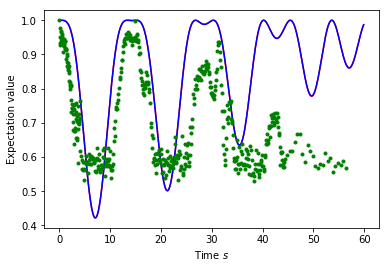

In [43]:
print("Model:", true_model)
plt.plot(
    times*10**6,
    ex_val_list, 
    color='r',
    ms = 40, 
    markevery=10
)

plt.plot(
    times*10**6,
    ex_val_list_check, 
    color='b'
)

plt.plot(xdata, ydata, "g.", label="Exp. Data")

plt.figsize=(15, 10)
plt.ylabel('Expectation value')
plt.xlabel('Time $s$')

# Check the role of different parameters

In [44]:
n_qubits = 2

### Within the Secular Approximation 

In [45]:
true_model_terms_params = {
    # spin
    'pauliSet_1_I_d{}'.format(n_qubits) : [2.87e9],
    'pauliSet_1_z_d{}'.format(n_qubits) : [2e8, 2e9, 2e10],
    
    'pauliSet_1J2_zJz_d{}'.format(n_qubits) : [0.05e6, 0.2e6, 0.5e6], 
    'pauliSet_1J2_yJy_d{}'.format(n_qubits) : [0.05e6, 0.2e6, 0.5e6], 
    'pauliSet_1J2_xJx_d{}'.format(n_qubits) : [0.05e6, 0.2e6, 0.5e6], 

#     # carbon nuclei - 2nd qubit
    'pauliSet_2_x_d{}'.format(n_qubits) : [10e3, 70e3, 150e3],
    'pauliSet_2_y_d{}'.format(n_qubits) : [10e3, 70e3, 150e3],
    'pauliSet_2_z_d{}'.format(n_qubits) : [10e3, 70e3, 150e3] 
}

check that the HF_z coupling actually affects the Hahn dynamics

In [48]:
%run revival_data_lib.py

In [49]:
%matplotlib inline

In [50]:
Ham_list = retrieve_Hams_list(true_model_terms_params, 2, 'pauliSet_1J2_zJz_d2')

In [51]:
all_exvals = []

for hamiltonian in Ham_list:

    expectation_values = {
        t : qmla.shared_functionality.n_qubit_hahn_evolution(
            ham = hamiltonian, 
            t = t,
            state = probe
        )
        for t in times
    }

    all_exvals.append([expectation_values[t] for t in times])

Text(0.5, 0, 'Time $s$')

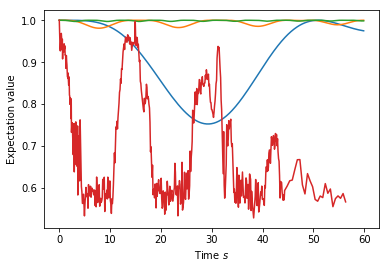

In [52]:
for ex_val_list in all_exvals:
    plt.plot(
        times*10**6,
        ex_val_list, 
        ms = 40, 
        markevery=10
    )

plt.plot(xdata, ydata, label="Exp. Data")

plt.figsize=(15, 10)
plt.ylabel('Expectation value')
plt.xlabel('Time $s$')

check that the R_z electron spin rotation actually affects the Hahn dynamics

In [53]:
Ham_list = retrieve_Hams_list(true_model_terms_params, 2, 'pauliSet_1_z_d2')

In [54]:
all_exvals = []

for hamiltonian in Ham_list:

    expectation_values = {
        t : qmla.shared_functionality.n_qubit_hahn_evolution(
            ham = hamiltonian, 
            t = t,
            state = probe
        )
        for t in times
    }

    all_exvals.append([expectation_values[t] for t in times])

Text(0.5, 0, 'Time $s$')

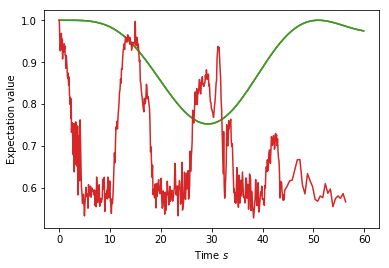

In [55]:
for ex_val_list in all_exvals:
    plt.plot(
        times*10**6,
        ex_val_list, 
        ms = 40, 
        markevery=10
    )

plt.plot(xdata, ydata, label="Exp. Data")

plt.figsize=(15, 10)
plt.ylabel('Expectation value')
plt.xlabel('Time $s$')

check that transverse terms (XX/YY) do not affect the dynamics

In [56]:
# Ham_list = retrieve_Hams_list(true_model_terms_params, 2, 'pauliSet_1J2_xJx_d2')
Ham_list = retrieve_Hams_list(true_model_terms_params, 2, 'pauliSet_1J2_yJy_d2')

In [57]:
all_exvals = []

for hamiltonian in Ham_list:

    expectation_values = {
        t : qmla.shared_functionality.n_qubit_hahn_evolution(
            ham = hamiltonian, 
            t = t,
            state = probe
        )
        for t in times
    }

    all_exvals.append([expectation_values[t] for t in times])

Text(0.5, 0, 'Time $s$')

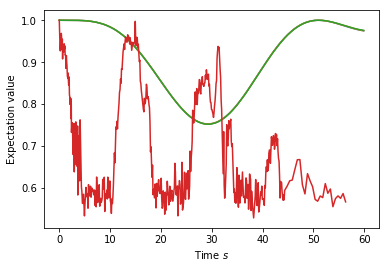

In [58]:
for ex_val_list in all_exvals:
    plt.plot(
        times*10**6,
        ex_val_list, 
        ms = 40, 
        markevery=10
    )

plt.plot(xdata, ydata, label="Exp. Data")

plt.figsize=(15, 10)
plt.ylabel('Expectation value')
plt.xlabel('Time $s$')

### beyond secular approximation, only transverse terms (not hyperfine off-diagonal)

In [59]:
true_model_terms_params = {
    # spin
    'pauliSet_1_I_d{}'.format(n_qubits) : [2.87e9],
    
    'pauliSet_1_x_d{}'.format(n_qubits) : [2e8, 2e9, 2e10],
    'pauliSet_1_y_d{}'.format(n_qubits) : [2e8, 2e9, 2e10],
    'pauliSet_1_z_d{}'.format(n_qubits) : [2e8, 2e9, 2e10],
    
    'pauliSet_1J2_zJz_d{}'.format(n_qubits) : [0.05e6, 0.2e6, 0.5e6], 
    'pauliSet_1J2_yJy_d{}'.format(n_qubits) : [0.05e6, 0.2e6, 0.5e6], 
    'pauliSet_1J2_xJx_d{}'.format(n_qubits) : [0.05e6, 0.2e6, 0.5e6], 

#     # carbon nuclei - 2nd qubit
    'pauliSet_2_x_d{}'.format(n_qubits) : [10e3, 70e3, 150e3],
    'pauliSet_2_y_d{}'.format(n_qubits) : [10e3, 70e3, 150e3],
    'pauliSet_2_z_d{}'.format(n_qubits) : [10e3, 70e3, 150e3] 
}

check that the transverse terms NOW affect the dynamics

In [60]:
# Ham_list = retrieve_Hams_list(true_model_terms_params, 2, 'pauliSet_1J2_yJy_d2')
Ham_list = retrieve_Hams_list(true_model_terms_params, 2, 'pauliSet_1J2_xJx_d2')

In [61]:
all_exvals = []

for hamiltonian in Ham_list:

    expectation_values = {
        t : qmla.shared_functionality.n_qubit_hahn_evolution(
            ham = hamiltonian, 
            t = t,
            state = probe
        )
        for t in times
    }

    all_exvals.append([expectation_values[t] for t in times])

Text(0.5, 0, 'Time $s$')

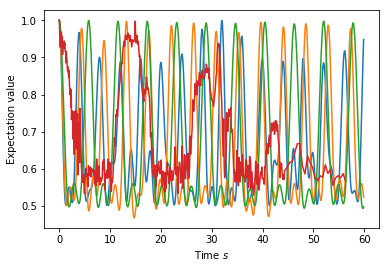

In [62]:
for ex_val_list in all_exvals:
    plt.plot(
        times*10**6,
        ex_val_list, 
        ms = 40, 
        markevery=10
    )

plt.plot(xdata, ydata, label="Exp. Data")

plt.figsize=(15, 10)
plt.ylabel('Expectation value')
plt.xlabel('Time $s$')

check that the electron spin rotation terms now do something

In [63]:
Ham_list = retrieve_Hams_list(true_model_terms_params, 2, 'pauliSet_1_z_d2')
# Ham_list = retrieve_Hams_list(true_model_terms_params, 2, 'pauliSet_1_y_d2')
# Ham_list = retrieve_Hams_list(true_model_terms_params, 2, 'pauliSet_1_x_d2')

In [64]:
all_exvals = []

for hamiltonian in Ham_list:

    expectation_values = {
        t : qmla.shared_functionality.n_qubit_hahn_evolution(
            ham = hamiltonian, 
            t = t,
            state = probe
        )
        for t in times
    }

    all_exvals.append([expectation_values[t] for t in times])

Text(0.5, 0, 'Time $s$')

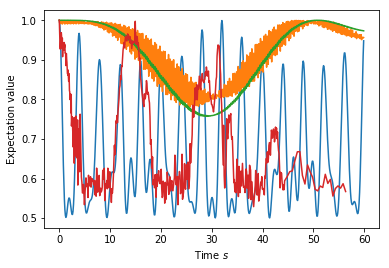

In [65]:
for ex_val_list in all_exvals:
    plt.plot(
        times*10**6,
        ex_val_list, 
        ms = 40, 
        markevery=10
    )

plt.plot(xdata, ydata, label="Exp. Data")

plt.figsize=(15, 10)
plt.ylabel('Expectation value')
plt.xlabel('Time $s$')